# Dec 24th, 2022 (AD: full brain, draft)

**Motivation**: save both run and session level, this one contains kmeans on mega animal <br>

In [1]:
# HIDE CODE


import os
import sys
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from scipy.ndimage import gaussian_filter
from IPython.display import display, IFrame, HTML

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
fig_base_dir = pjoin(git_dir, 'jb-Ca-fMRI/figs')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')

# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from figures.fighelper import *
from analysis.final import *
from utils.render import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tqdm.notebook import tqdm
%matplotlib inline
set_style()

In [2]:
from register.register import Register, reset_ants_img
from sklearn.cluster import KMeans

mice = Mice(128, load_parcel=True)
mice.set_band(band_bo=(0.008,0.28))
reg = Register(mice)

ROI lookup not found, time to run organize_func() . . .

combine metadata not found, time to run cat_data() . . .

In [3]:
# obj = reg.register_anat(save_results=True, anchor_ses=2)

100%|██████████| 10/10 [04:33<00:00, 27.33s/it]


## Load brain object in N162

In [3]:
brain = 'Symmetric_N162_space-indiv3d_brain.nii.gz'
brain = ants.image_read(
    filename=pjoin(mice.cfg.masks_dir, brain),
    pixeltype='unsigned int',
)
brain

ANTsImage (RAI)
         Pixel Type : unsigned int (uint32)
         Components : 1
         Dimensions : (60, 46, 81)
         Spacing    : (0.2, 0.2, 0.2)
         Origin     : (6.4, -6.2, -7.8)
         Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [4]:
brain = brain.numpy()[::-1][:, ::-1]
brain.shape

(60, 46, 81)

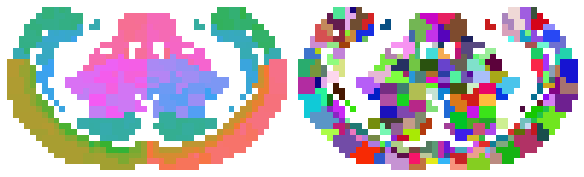

In [5]:
x2p = brain[..., 40].T.copy()
x2p = filter_boundaries(x2p)
for i, r in enumerate(np.unique(x2p[x2p.nonzero()]), start=1):
    x2p[x2p == r] = i
x2p = mwh(x2p == 0, x2p)
fig, axes = create_figure(1, 2, (8, 3), constrained_layout=True)
axes[0].imshow(mwh(x2p == 0, x2p), cmap=sns.color_palette('husl', as_cmap=True))
axes[1].imshow(mwh(x2p == 0, x2p), cmap=get_rand_cmap(len(np.unique(x2p[x2p.nonzero()]))))
remove_ticks(axes)
plt.show()

In [6]:
regions = mice.parcel.df['id'].values
regions_in_brain = np.unique(brain[brain.nonzero()])
len(regions), len(regions_in_brain)

(2782, 2775)

## Get files, xtract

In [7]:
files = sorted(filter(
    lambda f: 'sub-DKI' in f or 'sub-WT'in f,
    os.listdir(mice.cfg.raw_dir),
))
len(files)

348

### Masks all

In [8]:
masks = []
for f in tqdm(files):
    x = ants.image_read(pjoin(mice.cfg.raw_dir, f))
    masks.append(np.abs(x.numpy()).sum(-1) > 0)
mask_and = functools.reduce(np.logical_and, masks)
mask_or = functools.reduce(np.logical_or, masks)

_ = save_obj(
    obj=mask_and,
    file_name='AD_mask_and',
    save_dir=tmp_dir,
    mode='npy',
)
_ = save_obj(
    obj=mask_or,
    file_name='AD_mask_or',
    save_dir=tmp_dir,
    mode='npy',
)

  0%|          | 0/348 [00:00<?, ?it/s]

[PROGRESS] 'AD_mask_and.npy' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp

[PROGRESS] 'AD_mask_or.npy' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp

In [10]:
brain[~mask_or] = 0

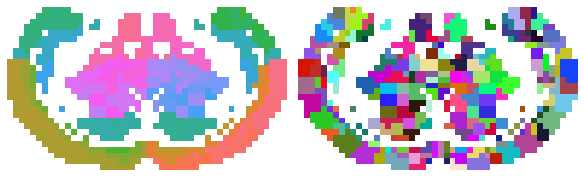

In [11]:
x2p = brain[..., 40].T.copy()
x2p = filter_boundaries(x2p)
for i, r in enumerate(np.unique(x2p[x2p.nonzero()]), start=1):
    x2p[x2p == r] = i
x2p = mwh(x2p == 0, x2p)
fig, axes = create_figure(1, 2, (8, 3), constrained_layout=True)
axes[0].imshow(mwh(x2p == 0, x2p), cmap=sns.color_palette('husl', as_cmap=True))
axes[1].imshow(mwh(x2p == 0, x2p), cmap=get_rand_cmap(len(np.unique(x2p[x2p.nonzero()]))))
remove_ticks(axes)
plt.show()

In [12]:
regions = np.unique(brain[brain.nonzero()])
node2region = {
    n: r for n, r in
    enumerate(regions)
}
len(node2region)

2368

In [13]:
n2l = {}
for n, r in node2region.items():
    info = mice.parcel.get(r)
    if info['acro'] == 'Isocortex':
        n2l[n] = f"{info['hemis']}-{info['region']}-{info['layer']}"
    else:
        n2l[n] = f"{info['hemis']}-{info['region']}"
mice.node_lookup['bold'] = n2l
mice.node_lookup['ca2'] = {
    n: lbl for n, lbl in n2l.items()
    if len(lbl.split('-')) == 3
}
bs = Base(mice, mode='ca2')

### Data all

In [13]:
data_all = {}
for f in tqdm(files):
    key = '_'.join(f.split('_')[:3])
    x = pjoin(mice.cfg.raw_dir, f)
    x = ants.image_read(x).numpy()
    data = np_nans((len(node2region), x.shape[-1]))
    for n, r in node2region.items():
        m = brain == r
        if m.sum() == 0:
            print(r)
            continue
        y = x[m].mean(0)
        if y.std() == 0:
            continue
        data[n] = y
    data_all[key] = data

_ = save_obj(
    obj=data_all,
    file_name='AD_data',
    save_dir=tmp_dir,
    mode='npy',
)

  0%|          | 0/348 [00:00<?, ?it/s]

[PROGRESS] 'AD_data.npy' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp

## Mega animal?

In [14]:
mega = {
    g: np.concatenate([
        x for _, x in filter(
            lambda tup: g in tup[0],
            data_all.items(),
        )], -1) for g in ['DKI', 'WT']
}
{k: v.shape for k, v in mega.items()}

{'DKI': (2368, 66239), 'WT': (2368, 37141)}

In [15]:
%%time

a_mega_dki, _ = get_adj_mat(mega['DKI'], 'pearson', p_val=1)
a_mega_wt, _ = get_adj_mat(mega['WT'], 'pearson', p_val=1)
delta = (a_mega_wt - a_mega_dki) / np.maximum(a_mega_wt, 1e-8)

CPU times: user 1min 54s, sys: 36.6 s, total: 2min 31s
Wall time: 18min 1s


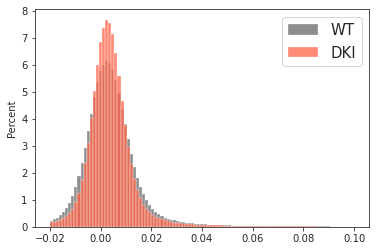

In [16]:
sns.histplot(a_mega_wt[a_mega_wt.nonzero()], color='dimgrey',
             label='WT', bins=np.linspace(-0.02, 0.1, 100), stat='percent')
sns.histplot(a_mega_dki[a_mega_dki.nonzero()], color='tomato',
             label='DKI', bins=np.linspace(-0.02, 0.1, 100), stat='percent')
plt.legend(fontsize=15)
plt.show()

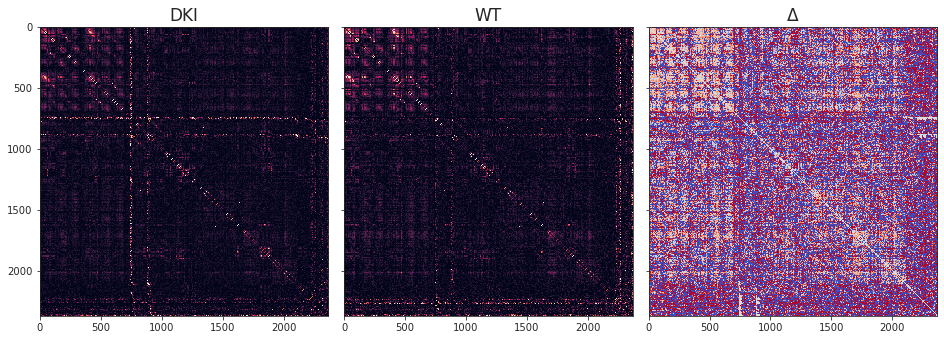

In [20]:
fig, axes = create_figure(1, 3, (13, 4.5), 'all', 'all', constrained_layout=True)
axes[0].imshow(a_mega_dki, vmin=0, vmax=0.1)
axes[1].imshow(a_mega_wt, vmin=0, vmax=0.1)
axes[2].imshow(delta, cmap='coolwarm', vmin=-1, vmax=1)

axes[0].set_title('DKI', fontsize=17)
axes[1].set_title('WT', fontsize=17)
axes[2].set_title(r"$\Delta$", fontsize=17)
plt.show()

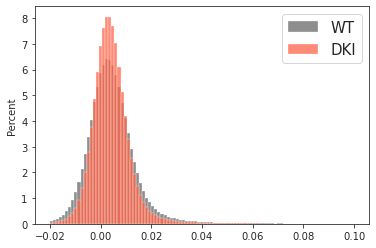

In [32]:
# Was with mask_and

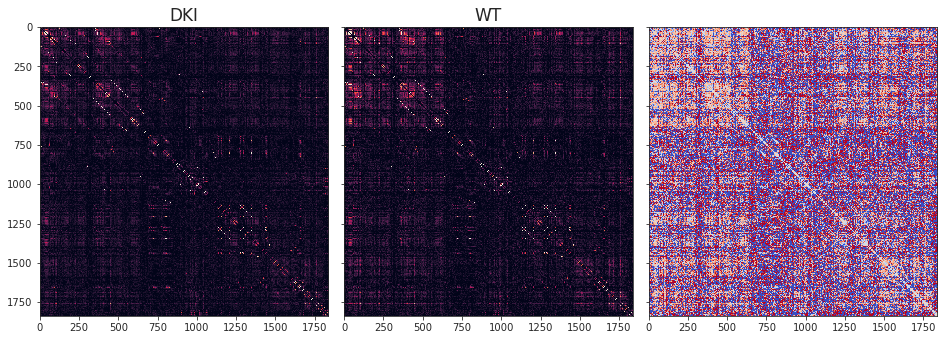

In [36]:
# Was with mask_and

### KMeans

In [56]:
num_k = 25
cmap = get_cluster_cmap(range(num_k))

km_dki = KMeans(n_clusters=num_k, random_state=0).fit(a_mega_dki)
km_wt = KMeans(n_clusters=num_k, random_state=0).fit(a_mega_wt)
partition_dki = km_dki.labels_ + 1
partition_wt = km_wt.labels_ + 1

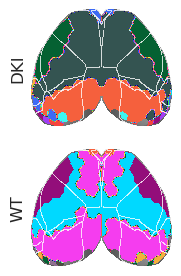

In [57]:
_ = bs.show({
    'DKI': partition_dki,
    'WT': partition_wt},
    cmap=cmap,
    vmin=None,
    vmax=None,
    proj='top',
    interpolation='none',
)

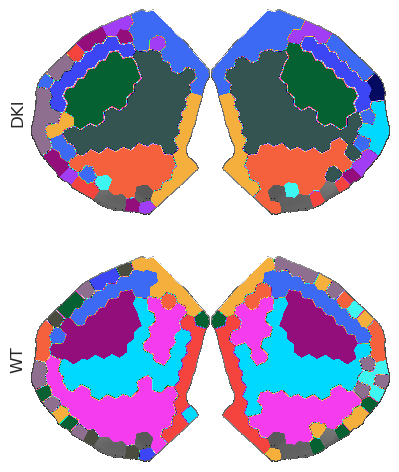

In [58]:
_ = bs.show({
    'DKI': partition_dki,
    'WT': partition_wt},
    cmap=cmap,
    vmin=None,
    vmax=None,
    proj='flat',
    contour=False,
    interpolation='none',
    figsize=(5, 6),
)

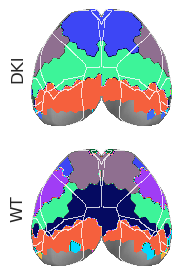

In [73]:
# Was with mask_and

In [59]:
results_dki = np.zeros_like(mice.parcel['brain'])
results_wt = np.zeros_like(mice.parcel['brain'])
for n, r in node2region.items():
    m = mice.parcel['brain'] == r
    results_dki[m] = partition_dki[n]
    results_wt[m] = partition_wt[n]

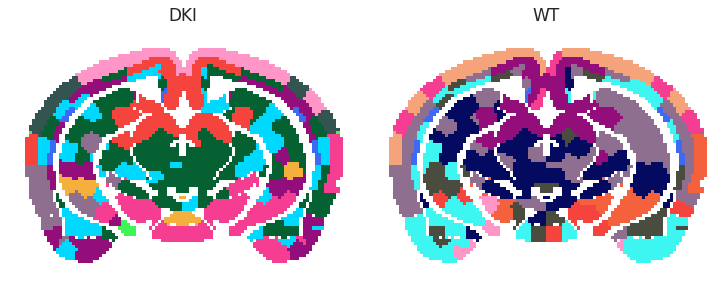

In [69]:
fig, axes = create_figure(1, 2, (10, 4), constrained_layout=True)
axes[0].imshow(mwh(mice.parcel['brain'][80] == 0, results_dki[80]), cmap=cmap)
axes[1].imshow(mwh(mice.parcel['brain'][80] == 0, results_wt[80]), cmap=cmap)

axes[0].set_title('DKI', fontsize=17, y=1.06)
axes[1].set_title('WT', fontsize=17, y=1.06)
remove_ticks(axes)
plt.show()

In [77]:
num_k = 7
cmap = get_cluster_cmap(range(num_k))

km_dki = KMeans(n_clusters=num_k, random_state=0).fit(a_mega_dki)
km_wt = KMeans(n_clusters=num_k, random_state=0).fit(a_mega_wt)
partition_dki = km_dki.labels_ + 1
partition_wt = km_wt.labels_ + 1

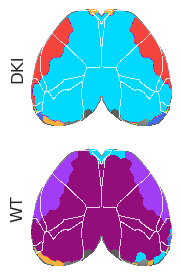

In [78]:
_ = bs.show({
    'DKI': partition_dki,
    'WT': partition_wt},
    cmap=cmap,
    vmin=None,
    vmax=None,
    proj='top',
    interpolation='none',
)

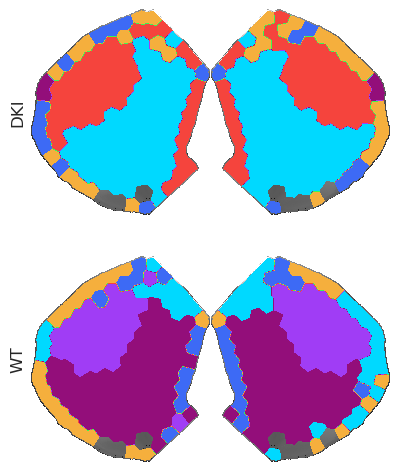

In [79]:
_ = bs.show({
    'DKI': partition_dki,
    'WT': partition_wt},
    cmap=cmap,
    vmin=None,
    vmax=None,
    proj='flat',
    contour=False,
    interpolation='none',
    figsize=(5, 6),
)

In [80]:
results_dki = np.zeros_like(mice.parcel['brain'])
results_wt = np.zeros_like(mice.parcel['brain'])
for n, r in node2region.items():
    m = mice.parcel['brain'] == r
    results_dki[m] = partition_dki[n]
    results_wt[m] = partition_wt[n]

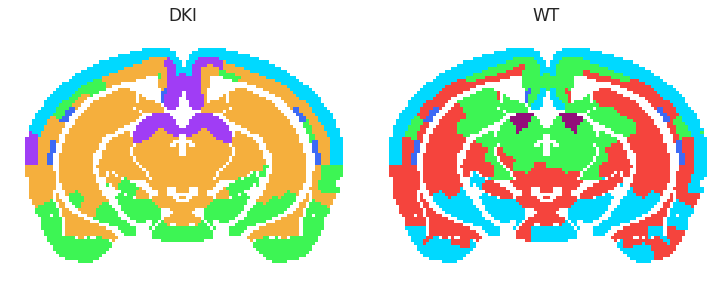

In [81]:
fig, axes = create_figure(1, 2, (10, 4), constrained_layout=True)
axes[0].imshow(mwh(mice.parcel['brain'][80] == 0, results_dki[80]), cmap=cmap)
axes[1].imshow(mwh(mice.parcel['brain'][80] == 0, results_wt[80]), cmap=cmap)

axes[0].set_title('DKI', fontsize=17, y=1.06)
axes[1].set_title('WT', fontsize=17, y=1.06)
remove_ticks(axes)
plt.show()